In [2]:
import pickle

# imoprt data science libraries
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import numpy as np

# Import ML libraries
import keras
import model_utils as mutils
from model_utils.evaluation import get_metrics, evaluate_model, table
from sklearn.preprocessing import StandardScaler
import pyod
# from pyod.models.mo_gaal import MO_GAAL

current_k_fold=10
SEED=current_k_fold**3
np.random.seed(SEED)

# pandas options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# deserialize pre-processed data
path_to_pickle = f'../data/kddcup/kdd_preprocessed_k{current_k_fold}.pkl'

with open(path_to_pickle, "rb") as f:
    data = pickle.load(f)
    X_train = data["X_train"].to_numpy()
    y_train = data["y_train"].to_numpy()

    X_val = data["X_val"].to_numpy()
    y_val = data["y_val"].to_numpy()

    X_test = data["X_test"].to_numpy()
    y_test = data["y_test"].to_numpy()

    col_names = data["col_names"]

print("Data loaded successfully")

# get imbalance ratio for each data set
IR_train = mutils.imb_ratio(data["y_train"].value_counts())
IR_val = mutils.imb_ratio(data["y_val"].value_counts())
IR_test = mutils.imb_ratio(data["y_test"].value_counts())

# print imbalance ratios. They should be (nearly) the same. pct = 0.172 such as in the paper!
print(f"Imbalance ratio in training data: {IR_train}")
print(f"Imbalance ratio in validation data: {IR_val}")
print(f"Imbalance ratio in test data: {IR_test}")

# print number of samples in each data set
print(f"\nNumber of samples in training data: {len(y_train)}")
print(f"Number of samples in validation data: {len(y_val)}")
print(f"Number of samples in test data: {len(y_test)}")

# Reshape
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

# print number of samples in each data set
print(f"\nNumber of samples in training data: {len(y_train)}")
print(f"Number of samples in validation data: {len(y_val)}")
print(f"Number of samples in test data: {len(y_test)}")

# Normalize Data
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Data loaded successfully
Imbalance ratio in training data: 4.13
Imbalance ratio in validation data: 4.13
Imbalance ratio in test data: 4.13

Number of samples in training data: 248823
Number of samples in validation data: 31103
Number of samples in test data: 31103

Number of samples in training data: 248823
Number of samples in validation data: 31103
Number of samples in test data: 31103


In [ ]:
# -*- coding: utf-8 -*-
"""Multiple-Objective Generative Adversarial Active Learning.
Part of the codes are adapted from
https://github.com/leibinghe/GAAL-based-outlier-detection
"""
# Author: Winston Li <jk_zhengli@hotmail.com>
# License: BSD 2 clause

# Code slightly updated to run on Keras 3 by Markus Haug

from __future__ import division
from __future__ import print_function

from collections import defaultdict

import numpy as np
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted

from pyod.models.base import BaseDetector
from pyod.models.gaal_base import create_discriminator, create_generator

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD


class MO_GAAL(BaseDetector):
    """Multi-Objective Generative Adversarial Active Learning.

    MO_GAAL directly generates informative potential outliers to assist the
    classifier in describing a boundary that can separate outliers from normal
    data effectively. Moreover, to prevent the generator from falling into the
    mode collapsing problem, the network structure of SO-GAAL is expanded from
    a single generator (SO-GAAL) to multiple generators with different
    objectives (MO-GAAL) to generate a reasonable reference distribution for
    the whole dataset.
    Read more in the :cite:`liu2019generative`.

    Parameters
    ----------
    contamination : float in (0., 0.5), optional (default=0.1)
        The amount of contamination of the data set, i.e.
        the proportion of outliers in the data set. Used when fitting to
        define the threshold on the decision function.

    k : int, optional (default=10)
        The number of sub generators.

    stop_epochs : int, optional (default=20)
        The number of epochs of training. The number of total epochs equals to three times of stop_epochs.

    lr_d : float, optional (default=0.01)
        The learn rate of the discriminator.

    lr_g : float, optional (default=0.0001)
        The learn rate of the generator.


    momentum : float, optional (default=0.9)
        The momentum parameter for SGD.

    Attributes
    ----------
    decision_scores_ : numpy array of shape (n_samples,)
        The outlier scores of the training data.
        The higher, the more abnormal. Outliers tend to have higher
        scores. This value is available once the detector is fitted.

    threshold_ : float
        The threshold is based on ``contamination``. It is the
        ``n_samples * contamination`` most abnormal samples in
        ``decision_scores_``. The threshold is calculated for generating
        binary outlier labels.

    labels_ : int, either 0 or 1
        The binary labels of the training data. 0 stands for inliers
        and 1 for outliers/anomalies. It is generated by applying
        ``threshold_`` on ``decision_scores_``.
    """

    def __init__(self, k=10, stop_epochs=20, lr_d=0.01, lr_g=0.0001, momentum=0.9, contamination=0.1):
        super(MO_GAAL, self).__init__(contamination=contamination)
        self.k = k
        self.stop_epochs = stop_epochs
        self.lr_d = lr_d
        self.lr_g = lr_g
        self.momentum = momentum

    def fit(self, X, y=None):
        """Fit detector. y is ignored in unsupervised methods.

        Parameters
        ----------
        X : numpy array of shape (n_samples, n_features)
            The input samples.

        y : Ignored
            Not used, present for API consistency by convention.

        Returns
        -------
        self : object
            Fitted estimator.
        """

        X = check_array(X)
        self._set_n_classes(y)
        self.train_history = defaultdict(list)
        names = locals()
        epochs = self.stop_epochs * 3
        stop = 0
        latent_size = X.shape[1]
        data_size = X.shape[0]
        # Create discriminator
        self.discriminator = create_discriminator(latent_size, data_size)
        self.discriminator.compile(
            optimizer=SGD(learning_rate=self.lr_d, momentum=self.momentum), loss='binary_crossentropy')

        # Create k combine models
        for i in range(self.k):
            names['sub_generator' + str(i)] = create_generator(latent_size)
            latent = Input(shape=(latent_size,))
            names['fake' + str(i)] = names['sub_generator' + str(i)](latent)
            self.discriminator.trainable = False
            names['fake' + str(i)] = self.discriminator(names['fake' + str(i)])
            names['combine_model' + str(i)] = Model(latent,
                                                    names['fake' + str(i)])
            names['combine_model' + str(i)].compile(
                optimizer=SGD(learning_rate=self.lr_g,
                              momentum=self.momentum),
                loss='binary_crossentropy')

        # Start iteration
        for epoch in range(epochs):
            print('Epoch {} of {}'.format(epoch + 1, epochs))
            batch_size = min(500, data_size)
            num_batches = int(data_size / batch_size)

            for index in range(num_batches):
                print('\nTesting for epoch {} index {}:'.format(epoch + 1,
                                                                index + 1))

                # Generate noise
                noise_size = batch_size
                noise = np.random.uniform(0, 1, (int(noise_size), latent_size))

                # Get training data
                data_batch = X[index * batch_size: (index + 1) * batch_size]

                # Generate potential outliers
                block = ((1 + self.k) * self.k) // 2
                for i in range(self.k):
                    if i != (self.k - 1):
                        noise_start = int(
                            (((self.k + (self.k - i + 1)) * i) / 2) * (
                                    noise_size // block))
                        noise_end = int(
                            (((self.k + (self.k - i)) * (i + 1)) / 2) * (
                                    noise_size // block))
                        names['noise' + str(i)] = noise[noise_start:noise_end]
                        names['generated_data' + str(i)] = names[
                            'sub_generator' + str(i)].predict(
                            names['noise' + str(i)], verbose=0)
                    else:
                        noise_start = int(
                            (((self.k + (self.k - i + 1)) * i) / 2) * (
                                    noise_size // block))
                        names['noise' + str(i)] = noise[noise_start:noise_size]
                        names['generated_data' + str(i)] = names[
                            'sub_generator' + str(i)].predict(
                            names['noise' + str(i)], verbose=0)

                # Concatenate real data to generated data
                for i in range(self.k):
                    if i == 0:
                        x = np.concatenate(
                            (data_batch, names['generated_data' + str(i)]))
                    else:
                        x = np.concatenate(
                            (x, names['generated_data' + str(i)]))
                y = np.array([1] * batch_size + [0] * int(noise_size))

                # Train discriminator
                discriminator_loss = self.discriminator.train_on_batch(x, y)
                self.train_history['discriminator_loss'].append(
                    discriminator_loss)

                # Get the target value of sub-generator
                pred_scores = self.discriminator.predict(X).ravel()

                for i in range(self.k):
                    names['T' + str(i)] = np.percentile(pred_scores,
                                                        i / self.k * 100)
                    names['trick' + str(i)] = np.array(
                        [float(names['T' + str(i)])] * noise_size)

                # Train generator
                noise = np.random.uniform(0, 1, (int(noise_size), latent_size))
                if stop == 0:
                    for i in range(self.k):
                        names['sub_generator' + str(i) + '_loss'] = \
                            names['combine_model' + str(i)].train_on_batch(
                                noise, names['trick' + str(i)])
                        self.train_history[
                            'sub_generator{}_loss'.format(i)].append(
                            names['sub_generator' + str(i) + '_loss'])
                else:
                    for i in range(self.k):
                        names['sub_generator' + str(i) + '_loss'] = names[
                            'combine_model' + str(i)].evaluate(noise, names[
                            'trick' + str(i)])
                        self.train_history[
                            'sub_generator{}_loss'.format(i)].append(
                            names['sub_generator' + str(i) + '_loss'])

                generator_loss = 0
                for i in range(self.k):
                    # Access the last loss value which is the most recent one
                    generator_loss += names['sub_generator' + str(i) + '_loss'][-1]

                generator_loss = generator_loss / self.k
                self.train_history['generator_loss'].append(generator_loss)

                # Stop training generator
                if epoch + 1 > self.stop_epochs:
                    stop = 1

        # Detection result
        self.decision_scores_ = self.discriminator.predict(X).ravel()
        self._process_decision_scores()
        return self

    def decision_function(self, X):
        """Predict raw anomaly score of X using the fitted detector.

        The anomaly score of an input sample is computed based on different
        detector algorithms. For consistency, outliers are assigned with
        larger anomaly scores.

        Parameters
        ----------
        X : numpy array of shape (n_samples, n_features)
            The training input samples. Sparse matrices are accepted only
            if they are supported by the base estimator.

        Returns
        -------
        anomaly_scores : numpy array of shape (n_samples,)
            The anomaly score of the input samples.
        """
        check_is_fitted(self, ['discriminator'])
        X = check_array(X)
        pred_scores = self.discriminator.predict(X).ravel()
        return pred_scores




In [ ]:
# MO-GAAL hyperparameters from Hajek et al. 2023:

contamination = len(y_train[y_train == 1]) / len(y_train) # proportion of frauds in the training dataset
n_sub_generators = 5
lr_discriminator = 0.01
lr_generator = 0.0001
epochs = 1

mo_gaal = MO_GAAL(
    k=n_sub_generators,
    stop_epochs=epochs,
    contamination=contamination,
    lr_d=lr_discriminator,
    lr_g=lr_generator,
)

# train in supervised manner
clf = mo_gaal.fit(X_train, y_train) # 89 min with 1 epoch an n_sub_generators = 5

In [5]:
scores = mo_gaal.predict_proba(X_test)

972/972 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step


In [6]:
scores_normal = df(mo_gaal.predict_proba(df(X_train)[y_train == 0])[:,1])
scores_anomal = df(mo_gaal.predict_proba(df(X_train)[y_train == 1])[:, 0])

6261/6261 ━━━━━━━━━━━━━━━━━━━━ 2s 297us/step
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 1s 354us/step


<Axes: ylabel='Frequency'>

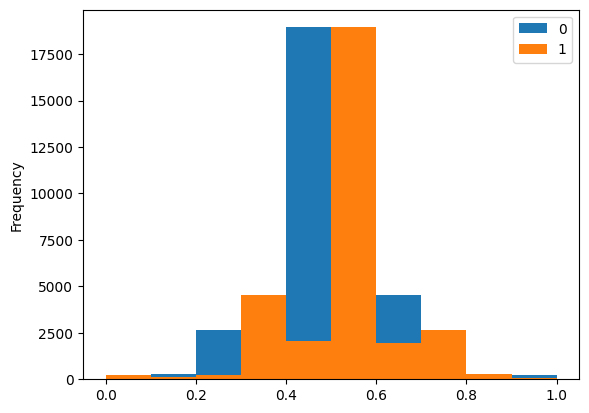

In [10]:
df(scores).plot(kind='hist')

In [21]:
# let's find the best threshold

best_metric = 0.
best_th = 0.

for threshold in np.arange(0.0, 1.0, 0.001):
    current_metric = get_metrics(y_test, scores[:, 1], op=">", threshold=threshold)["F1"]
    if current_metric > best_metric:
        best_metric = current_metric
        best_th = threshold

print("Best Metric Score:", best_metric)
print("Best Threshold: ", best_th)

Best Metric Score: 0.8301
Best Threshold:  0.562


In [23]:
get_metrics(y_test, scores[:, 1], threshold=0.562)

{'tn': 23327.0,
 'fp': 1716.0,
 'fn': 543.0,
 'tp': 5517.0,
 'precision': 0.762754,
 'recall': 0.91039604,
 'AUCPRC': 0.7517,
 'F1': 0.8301,
 'ROCAUC': 0.911,
 'MCC': 0.7893,
 'ACC': 0.9274,
 'GMEAN': 0.9209}

In [7]:
from joblib import dump, load

dump(mo_gaal, './saved_models/MOGAAL/mo_gaal_kdd.joblib')

['./saved_models/MOGAAL/mo_gaal_kdd.joblib']

In [8]:
mo = load('./saved_models/MOGAAL/mo_gaal_kdd.joblib')